# ECG-based PUF

### 3.2 Data Pre Processing
Load the entire dataset and assign to variable ```dict_all_records```.

In [ ]:
import numpy as np
import wfdb
db_name = "ecgiddb/"
dict_all_records = dict()
f = open(db_name + "RECORDS", "r")
for y in f.readlines():
    person = y.split("/")[0].strip()
    record = y.split("/")[1].strip()
    # The record cannot be duplicate, so we can safely insert it everytime, w/o checking
    if person not in dict_all_records:
        dict_all_records[person] = {record: wfdb.rdrecord(db_name + person + "/" + record, sampfrom=0, channels=[1])}
    else:
        dict_all_records[person].update({record: wfdb.rdrecord(db_name + person + "/" + record, sampfrom=0, channels=[1])})

Detect QRS Complex on each signal in order to apply splitting and then proceed with filtering

In [ ]:
from wfdb import processing
dict_all_peaks = dict()
for person in dict_all_records:
    dict_all_peaks[person] = dict()
    for record in dict_all_records[person]:
        signal_detected = dict_all_records[person][record]
        qrs_inds = processing.qrs.gqrs_detect(sig=signal_detected.p_signal[:,0], fs=signal_detected.fs)
        if len(qrs_inds) < 1:
            continue
        # Correct the peaks shifting them to local maxima
        min_bpm = 20
        max_bpm = 230
        # min_gap = record.fs * 60 / min_bpm
        # Use the maximum possible bpm as the search radius
        search_radius = int(signal_detected.fs * 60 / max_bpm)
        corrected_peak_inds = processing.peaks.correct_peaks(signal_detected.p_signal[:,0], peak_inds=qrs_inds, search_radius=search_radius, smooth_window_size=150)
        dict_all_peaks[person][record] = sorted(corrected_peak_inds)

Split the signal using the QRS complex, creating windows of 160ms centered at R.

In [ ]:
splitted_signal = dict()
for person in dict_all_peaks:
    splitted_signal[person] = dict()
    for corrected_peak_inds in dict_all_peaks[person]:
        splitted_signal[person][corrected_peak_inds] = list()
        for r in dict_all_peaks[person][corrected_peak_inds]:
            if r<150 or r>9800:
                continue
            # Get from the original signal, at this point we can apply the noise removal algorithm
            current_seq = dict_all_records[person][corrected_peak_inds].p_signal[r-50:r+50].tolist()
            splitted_signal[person][corrected_peak_inds].append(current_seq)

### Apply filter on signal
### Butter filter

In [ ]:
import matplotlib.pyplot as plt
from scipy import signal

cutoff_frequency = 20
order = 1
sampling_rate = 100
b, a = signal.butter(order, cutoff_frequency / (sampling_rate / 2), btype='low')
filtered_dataset = dict()
for person in splitted_signal:
    filtered_dataset[person] = dict()
    for record in splitted_signal[person]:
        filtered_dataset[person][record] = list()
        test = splitted_signal[person][record]
        # Parsing to a list with single values
        for y in test:
            current_sign = list()
            for z in y:
                current_sign.append(z[0])
        test_filtered = signal.filtfilt(b, a, current_sign)
        filtered_dataset[person][record].append(test_filtered)

### No Fileter

In [ ]:
filtered_dataset = dict()
for person in splitted_signal:
    filtered_dataset[person] = dict()
    for record in splitted_signal[person]:
        filtered_dataset[person][record] = list()
        test = splitted_signal[person][record]
        # Parsing to a list with single values
        for y in test:
            current_sign = list()
            for z in y:
                current_sign.append(z[0])
            filtered_dataset[person][record].append(current_sign)

In [ ]:
from sympy import fwht
from sympy import fft
transformed_dataset = dict()
for person in filtered_dataset:
    transformed_dataset[person] = dict()
    for record in filtered_dataset[person]:
        sequences = np.average(filtered_dataset[person][record], axis=0)
        transformed_dataset[person][record] = fwht(sequences.ravel().tolist())

Create a dataset, where the value of singal are parsed in binary representation

In [ ]:
import struct
dict_binaries = dict()
for person in transformed_dataset:
    dict_binaries[person] = dict()
    for record in transformed_dataset[person]:
        final_string = list()
        dict_binaries[person][record] = list()
        for x in transformed_dataset[person][record]:
            final_string.append(''.join('{:0>8b}'.format(c) for c in struct.pack('!f', float(x))))
        final_string = ''.join(final_string)
        # Insert binary representation as single bit in an array
        for y in final_string:
            dict_binaries[person][record].append(y)

 ... or the signal is interpreted as variations ...

In [ ]:
import struct
dict_binaries = dict()
for person in transformed_dataset:
    dict_binaries[person] = dict()
    for record in transformed_dataset[person]:
        final_string = list()
        dict_binaries[person][record] = list()
        len_record = len(transformed_dataset[person][record])
        for index, x in enumerate(transformed_dataset[person][record]):
            if index != len_record - 1:
                if x < transformed_dataset[person][record][index + 1]:
                    dict_binaries[person][record].append(1)
                else:
                    dict_binaries[person][record].append(0)

In [39]:
import pandas as pd
# Let's compute the fractional Hamming Distance for each pair, only for intra distance
all_fhd_dataset = pd.DataFrame(columns=["p", "r1", "r2", "dist"])
complex_sum = 0
for person in dict_binaries:
    list_of_records = list(dict_binaries[person].values())
    for index1 in range(0, len(list_of_records) - 1):
        for index2 in range(index1 + 1, len(list_of_records)):
            first = np.array(list_of_records[index1], dtype=np.float64)
            second = np.array(list_of_records[index2], dtype=np.float64)
            fhd_ij = np.sum(np.abs(first - second))/len(first) # or second len, it is the same
            all_fhd_dataset.loc[len(all_fhd_dataset)] = [person, index1, index2, fhd_ij]

all_fhd_dataset

,p,r1,r2,dist
0,Person_01,0,1,0.358398
1,Person_01,0,2,0.369141
2,Person_01,0,3,0.374756
3,Person_01,0,4,0.381592
4,Person_01,0,5,0.358643
...,...,...,...,...
806,Person_88,0,1,0.471436
807,Person_88,0,2,0.486572
808,Person_88,1,2,0.349121
809,Person_89,0,1,0.373291


In [ ]:
all_persons = list(dict_binaries.keys())
size_all_persons = len(all_persons)
all_fhd_dataset_full = pd.DataFrame(columns=["p1", "p2", "r1", "r2", "dist"])
for index1 in range(0, size_all_persons - 1):
    # Per ciascun record della prima persona
    for records_index1 in dict_binaries[all_persons[index1]]:
        # Confronta il record corrente con tutti i record di tutte le altre persone
        for index2 in range(index1 + 1, size_all_persons):
            for records_index2 in dict_binaries[all_persons[index2]]:
                first = np.array(dict_binaries[all_persons[index1]][records_index1], dtype=np.float64)
                second = np.array(dict_binaries[all_persons[index2]][records_index2], dtype=np.float64)
                fhd_ij = np.sum(np.abs(first - second))/len(first) # or second len, it is the same
                all_fhd_dataset_full.loc[len(all_fhd_dataset_full)] = [all_persons[index1], all_persons[index2], records_index1, records_index2, fhd_ij]
all_fhd_dataset_full

## Comupte the fHD

First, evaluate only over the same day, then we evaluate over all the days of experimentation.

In [ ]:
sameday_records_intra = all_fhd_dataset[all_fhd_dataset['r1'].isin([0, 1]) & all_fhd_dataset['r2'].isin([0, 1])]
sameday_records_inter = all_fhd_dataset_full[all_fhd_dataset_full['r1'].isin(["rec_1", "rec_2"]) & all_fhd_dataset_full['r2'].isin(["rec_1", "rec_2"])]

/var/folders/5k/gnrk6j6x6z79v42dpz2bd76m0000gp/T/ipykernel_60791/3786806980.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sameday_records_intra['dist'], hist=False, rug=True)
/var/folders/5k/gnrk6j6x6z79v42dpz2bd76m0000gp/T/ipykernel_60791/3786806980.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad

<Axes: xlabel='dist', ylabel='Density'>

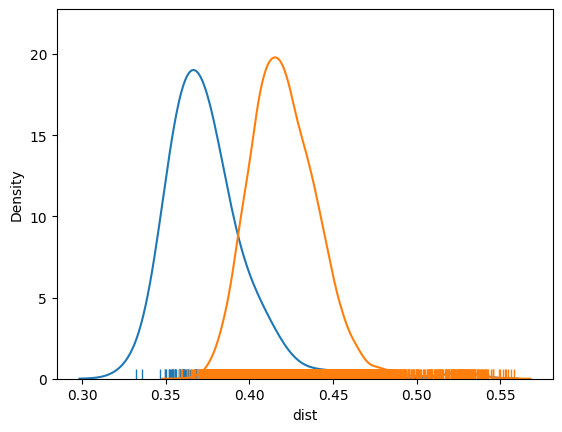

In [81]:
import seaborn as sns
sns.distplot(sameday_records_intra['dist'], hist=False, rug=True)
sns.distplot(sameday_records_inter['dist'], hist=False, rug=True)

Evaluate over all the dataset

/var/folders/5k/gnrk6j6x6z79v42dpz2bd76m0000gp/T/ipykernel_60791/1126329114.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_fhd_dataset['dist'], hist=False, rug=True)
/var/folders/5k/gnrk6j6x6z79v42dpz2bd76m0000gp/T/ipykernel_60791/1126329114.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad637275

<Axes: xlabel='dist', ylabel='Density'>

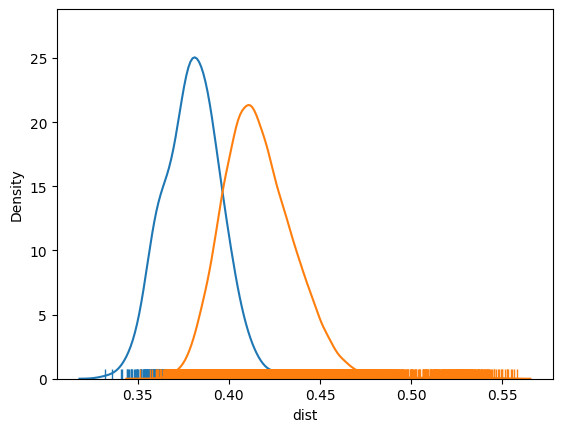

In [80]:
sns.distplot(all_fhd_dataset['dist'], hist=False, rug=True)
sns.distplot(all_fhd_dataset_full['dist'], hist=False, rug=True)

### Compute the uniqueness

/var/folders/5k/gnrk6j6x6z79v42dpz2bd76m0000gp/T/ipykernel_60791/221893138.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tot_uniq, hist=True, rug=True)


<Axes: ylabel='Density'>

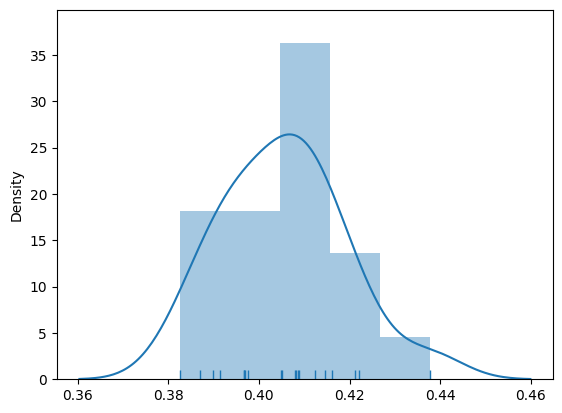

In [44]:
tot_uniq = list()
for y in dict_all_records['Person_01']:
    single_val = all_fhd_dataset_full[all_fhd_dataset_full['r1'].isin([y]) & all_fhd_dataset_full['r2'].isin([y])]
    tot_sum = np.sum(single_val['dist'])
    uniqueness = 1/len(single_val) * tot_sum 
    tot_uniq.append(uniqueness)
sns.distplot(tot_uniq, hist=True, rug=True)

### Compute the Stability

/var/folders/5k/gnrk6j6x6z79v42dpz2bd76m0000gp/T/ipykernel_60791/156814753.py:5: RuntimeWarning: invalid value encountered in scalar divide
  single_sum = np.sum(stab_ofperson['dist']) / len(stab_ofperson)
/var/folders/5k/gnrk6j6x6z79v42dpz2bd76m0000gp/T/ipykernel_60791/156814753.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tot_stab, hist=True, rug=True)


<Axes: ylabel='Density'>

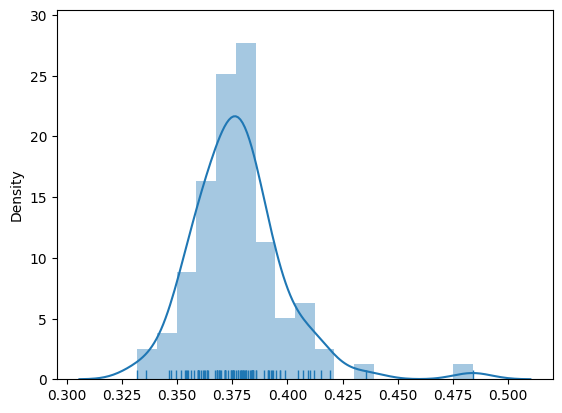

In [62]:
import math
tot_stab = list()
for person in dict_all_records:
    stab_ofperson = all_fhd_dataset[all_fhd_dataset['p'] == person]
    single_sum = np.sum(stab_ofperson['dist']) / len(stab_ofperson)
    if not math.isnan(single_sum):
        tot_stab.append(single_sum)
sns.distplot(tot_stab, hist=True, rug=True)

### Uniformity

/var/folders/5k/gnrk6j6x6z79v42dpz2bd76m0000gp/T/ipykernel_60791/4168449640.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tot_unif, hist=True, rug=True)


<Axes: ylabel='Density'>

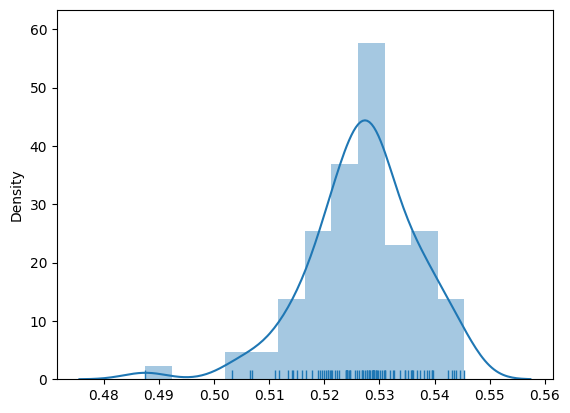

In [68]:
tot_unif = list()
for person in dict_all_records:
    current = dict_binaries[person]['rec_1']
    tot_ones = 0
    for x in current:
        if x == '1':
            tot_ones += 1
    tot_unif.append(tot_ones/len(current))
sns.distplot(tot_unif, hist=True, rug=True)

### Entropy

In [79]:
tot_sum = 0
for x in range(0, len(dict_binaries['Person_01']['rec_1'])):
    sum_current = 0
    for person in dict_binaries:
        sum_current += int(dict_binaries[person]['rec_1'][x])
    p_logic_1 = sum_current/len(dict_binaries)
    p_logic_0 = 1 - p_logic_1
    tot_sum -= math.log2(max(p_logic_1, p_logic_0))
print(tot_sum/len(dict_binaries['Person_01']['rec_1']))

0.7143133663815407
